In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import os
import re
import yaml
import sys
import subprocess
import math

# Parallel focusing 
This is python code written in jupyter notebook which implements different methods for point-point to parallel-parallel focusing. It uses software ASTRA, a program to simulate beam dynamics in accelerators. Programs in this notebook run in the same directory as are the ASTRA executables, mainly generator and Astra. 

The initial information are regarding the input file to Astra and information about reference particles. I used 5 different reference particles to determine the focusing properties of a setup- the first particle with 0 offset and 0 angle, moving along the z axis. This particle should not move in the transverse direction. Next 2 particles would be with initial offsets in the x and y directions respectively, but because this is point-point focusing, I am not using these. Last 2 have angles in the x and y direction respectively.

The magnets that are used are permanent quadrupole magnets with set gradients, lengths and bore diameters. These parameters can be changed, but for now they are set to values of 3 quadrupole magnets in LLR laboratory. The variables which will be changing are distances between them and the initial momentum. D1 is the distance from the source to the 1. quadrupole magnet. Realistically, D1 is only up to fringe fields which are magnetic fields outside the magnet's bores (reach 3*bore size in ASTRA). This option can be changed using TopHatShapedQuads() function. D2 and D3 are distances between first 2 and last 2 magnets in sequence. Last variable that can be changed is the initial longitudinal momentum of particles.

For running beam simulations, one can define it's initial parameters like spread of transverse momenta, spread of longitudinal energy, spread of offsets in the x and y directions as well as in the longitudinal direction. Also number of initial particles, space charge, secondary particle emission or other parameters can be changed in file parallelBeam.in.


In [2]:
fileName = "parallelBeam"
fillNumber = "001"
setupLength = 4 #m
setupLengthStr = "0400"
longitudalEnergy = "5.0E+8" #eV

#offsets and angles for reference particles
xoffset = "2.0E-4" #m
yoffset =  "2.0E-4" #m
xmom = "1.0E+6" #eV
ymom = "1.0E+6" #eV


#parameters of magnets 
lengthQ1 = 0.036  #m
lengthQ2 = 0.12  #m
lengthQ3 = 0.1  #m

boreQ1 = 0.007
boreQ2 = 0.018
boreQ3 = 0.030
topHatField = True

#input parameters of the beam
nParticles = "500"
sig_x=0.75E0  #gaussian distribution in x direction with this sigma
sig_y=0.75E0
sig_px = 0.075E0
sig_py = 0.075E0


In [3]:
dataD1 = []
dataD2 = []
dataD3 = []
dataMom = []
dataSum = []


## Function to change input settings
Function changeInputData() is a function created to change input variables for ASTRA. The first argument is the name of the parameter that needs to be changed, the second is the value. After that is topHatShapedQuads() which changes settings between ideal or realistic quadrupoles. To change the momentum in the z direction, one can use changeMomZ(). Files test0.ini all the way to test4.ini are input data for 5 different runs. File test0.ini has 0. reference particle with 0 offset and 0 initial angle, 1 and 2 have offsets in the x and y directions respectively and the last 2 have predefined angles. All of them should be parallel in the end. Lastly, function update() should be run to double check that all parameters are set to the right values.

In [4]:
def changeInputData(tag, newVar):
#universal function which changes input parameter in input file to Astra
    try:
        # Open the file for reading
        with open(fileName + ".in", 'r') as file:
            lines = file.readlines()

        # Prepare the replacement string
        replacement = " " + tag + "=" + newVar + "\n"

        # Iterate over the lines to find and replace the target line
        for i, line in enumerate(lines):
            if tag in line:
                lines[i] = replacement
                break  # Assuming there's only one occurrence to replace

        # Write the modified lines back to the file
        with open(fileName + ".in", 'w') as file:
            file.writelines(lines)

        #print(f"Replaced '{tag}' with '{replacement.strip()}'.")

    except FileNotFoundError:
        print("The file " + fileName + ".ini was not found.")
    except Exception as e:
        print(f"An error occurred when trying to change '{tag}' to variable '{newVar}': {e}")


    
    return

In [5]:
def topHatShapedQuads(ideal):
    #switcher between idealised quadrupoles without fringe fields or not

    global topHatField 
    topHatField = ideal

    if ideal:
        changeInputData("Q_bore(1)", "1E-9")
        changeInputData("Q_bore(2)", "1E-9")
        changeInputData("Q_bore(3)", "1E-9")
    else: 
        changeInputData("Q_bore(1)", str(boreQ1))
        changeInputData("Q_bore(2)", str(boreQ2))
        changeInputData("Q_bore(3)", str(boreQ3))

    
    return       

In [6]:
def changeMom(px, py, pz, xoff, yoff): 
    nameOfFiles = ["test0.ini", "test1.ini", "test2.ini" , "test3.ini", "test4.ini"]
    try:
        testData = ""

        #change longitudinal momentum for files test0.ini through test4.ini and test.ini
        for name in nameOfFiles:
            with open(name, "r") as file:
                line = file.readlines()[0].split()

            #offset update
            if name == "test3.ini" and xoff != -1:
                line[0] = str(xoff) 
            if name == "test4.ini" and yoff != -1:
                line[1] = str(yoff)
            if name == "test1.ini" and yoff != -1:
                line[1] = str(yoff) 
            if name == "test2.ini" and xoff != -1:
                line[0] = str(xoff)


            
            #momentum update
            if name == "test3.ini" and px != -1:
                line[3] = str(px)
            if name == "test4.ini" and py != -1:
                line[4] = str(py)
            if name == "test1.ini" and px != -1:
                line[3] = str(px)
            if name == "test2.ini" and py != -1:
                line[4] = str(py)
            
            line[5] = str(pz)

            inputData = ""
            for num in line:
                inputData += num + " "
            testData += inputData + "\n"
            with open(name, "w") as file:
                file.write(inputData)

    
        with open("test.ini","w") as file:
            file.write(testData)
    
        #generate new data with new momentum
        changeInputData("Ref_Ekin", str(pz))
        
        #uncomment once beam is being used!!!
        #subprocess.run("./generator " + fileName + " > output.txt" , shell=True,check=True,executable='/bin/bash' )
        #print(f"Successfully changed momentum to files and ran a generation of particles saved to '{fileName}'.")

    except FileNotFoundError:
        print("One of the files when changing initial offsets and momenta was not found.")
    except Exception as e:
        print(f"An error occurred when trying to change longitudinal momentum: {e}")

    return
    

In [30]:
def update():
    '''
    inputData = "  " + xoffset + "  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  5.0000E+08  0.0000E+00 -1.0000E-01   1   5"
    with open("test1.ini", "w") as file:
        file.write(inputData)

    inputData = "  0.0000E+00  " + yoffset + "  0.0000E+00  0.0000E+00  0.0000E+00  5.0000E+08  0.0000E+00 -1.0000E-01   1   5"
    with open("test2.ini", "w") as file:
        file.write(inputData)

    inputData = "  0.0000E+00  0.0000E+00  0.0000E+00 " + xmom + " 0.0000E+00  5.0000E+08  0.0000E+00 -1.0000E-01   1   5"
    with open("test3.ini", "w") as file:
        file.write(inputData)

    inputData = "  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00 " + ymom + " 5.0000E+08  0.0000E+00 -1.0000E-01   1   5"
    with open("test4.ini", "w") as file:
        file.write(inputData)   

    #change input energy
    changeInputData("Ref_Ekin", str(float(longitudalEnergy)/1E+6)) #input in MeV
    '''
    changeInputData("ZSTOP", str(setupLength) )

    #change properties of magnets
    changeInputData("Q_length(1)", str(lengthQ1))
    changeInputData("Q_length(2)", str(lengthQ2))
    changeInputData("Q_length(3)", str(lengthQ3))
    
    #change parameters of the beam
    changeInputData("IPart", str(nParticles))

    changeInputData("sig_x", str(sig_x))
    changeInputData("sig_y", str(sig_y))
    changeInputData("sig_px", str(sig_px))
    changeInputData("sig_py", str(sig_py))

    dataD1.clear()
    dataD2.clear()
    dataD3.clear()
    dataSum.clear()
    
    print(f"Succesfully updated all variables.")

    return

## Functions that make life easier
Here below are some one-liners or almost one-liners that run several times and return some specific values used in bigger algorithms implemented for example in refParticles().

In [8]:
def checkCavity(Q1pos, Q2pos, Q3pos):
    #this function checks if a reference particle touches wall of a cavity 
    #so far not calculating with offsets of quadrupoles
    
    data = loadDataRef("ref")

    for line in data:
        #check if it does not go beyond the cavity 1 limit
        if line[0] > (Q1pos - lengthQ1/2) and line[0] < (Q1pos+ lengthQ1/2): #m
            if line[5] > boreQ1*1e+3/2 or line[6] > boreQ1*1e+3/2: #mm
                print(f"Reference particle hit the cavity wall of Q1. Leaving...")
                return False

        #check if it does not go beyond the cavity 2 limit
        if line[0] > (Q2pos - lengthQ2/2) and line[0] < (Q2pos + lengthQ2/2): 
            if line[5] > boreQ2*1e+3/2 or line[6] > boreQ2*1e+3/2:
                print(f"Reference particle hit the cavity wall of Q2. Leaving...")
                return False
            
        #check if it does not go beyond the cavity 3 limit
        if line[0] > (Q3pos - lengthQ3/2) and line[0] < (Q3pos + lengthQ3/2): 
            if line[5] > boreQ3*1e+3/2 or line[6] > boreQ3*1e+3/2:
                print(f"Reference particle hit the cavity wall of Q3. Leaving...")
                return False


    return True

In [9]:
def isRef0Straight(px, py):
    #function which checks if 0. ref particle did not move
    if px == 0 and py == 0:
        return True
    else:
        return False

In [10]:
def differLine(line):
    #splits a line and converts string to float
    lineSplitted = line.split()
    
    return [float(num) for num in lineSplitted]    

In [11]:
def loadDataRef(arg):
#open and load data about reference particle
#z [m], t [ns], pz [MeV/c], dE/dz [MeV/c], Larmor Angle [rad], x off [mm], y off [mm], px [eV/c], py [eV/c]
    data = []
    #assuming setup length
    with open(fileName + "." + arg + "." + fillNumber,"r") as file:
        for line in file:
            newLine = differLine(line)
            data.append(newLine)

    return data
    

In [12]:
def fill4DGraph(D1, D2,D3,mom,sum):
    #function that fills info about each run, these data can be later used for some plots
    dataD1.append(D1)
    dataD2.append(D2)
    dataD3.append(D3)
    dataMom.append(mom)
    dataSum.append(sum)
    
    return

In [13]:
def angleCalculation(data):
    #calculate sum of transverse momenta in final state in mrad
    
    sum =  math.sqrt((data[1][3]/data[1][5])**2 + (data[1][4]/data[1][5])**2 + (data[2][4]/data[2][5])**2 + (data[2][3]/data[2][5])**2)*1e+3
    return sum

In [14]:
def angleCalculationInverse(data):
    #calculate sum of transverse momenta in final state in mrad
    
    sum =  math.sqrt((data[3][3]/data[3][5])**2 + (data[3][4]/data[3][5])**2 + (data[4][4]/data[4][5])**2 + (data[4][3]/data[4][5])**2 )*1e+3
    return sum

In [15]:
def angleCalculationX(data):
    # return angle in x direction in mrad
    sum =  data[1][3]*1e+3/data[1][5]
    return sum

In [16]:
def angleCalculationY(data):
    #return angle in y direction in mrad 
    sum = data[2][4]*1e+3/data[2][5]
    
    return sum

In [17]:
def giveRange(rangeVar, nInt):
    #function to determine whether a variable will be varied or not, if yes then determine the range
    output = []
    if rangeVar[0] != rangeVar[1]:
        interval =(rangeVar[1] - rangeVar[0])/nInt      
        for i in range(nInt):
            output.append(rangeVar[0] + i*interval)
    else:
        output.append(rangeVar[0])

    return output


# Function RunRef()
Function runRef() is the function that does most of the work. The arguments are the specific D1, D2, D3 and longitudinal momentum that is of interest. It is created for 3 reference particles: 0 angle, x angle, y angle. It changes the variables in the input file for Astra, runs the program for each reference particle separately, loads the output of the program. If argument moreData is set to True, it returns the entire trajectories of the particles, if it is false only information at the end of setup. 

In [18]:
def runRef(D1, D2, D3,momZ, moreData):
    #this function runs Astra with 5 different reference particles for specific D1,D2,D3

    Q1pos = D1 + lengthQ1/2
    Q2pos = D1 + lengthQ1 + D2 + lengthQ2/2
    Q3pos = D1 + lengthQ1 + D2 + lengthQ2 + D3 + lengthQ3/2
    
    changeInputData("Q_pos(1)",str(Q1pos))
    changeInputData("Q_pos(2)",str(Q2pos) )
    changeInputData("Q_pos(3)",str(Q3pos) )
    changeMom(-1, -1, momZ, -1, -1)


    #if moreData, then provide tracking for each of the reference particles and return it for plotting
    if moreData:
        inputDataName = ["test0.ini", "test3.ini", "test4.ini", "test1.ini", "test2.ini"]
        outputMoreData = []
        for i in range(len(inputDataName)):
            changeInputData("Distribution", inputDataName[i] )
            result = subprocess.run("source /opt/intel/oneapi/setvars.sh > out.txt && ./Astra " + fileName + " > output.txt",capture_output=True, text=True, shell=True,check=True,executable='/bin/bash' )

            if result.returncode != 0:
                print(f"Astra returned an error '{subprocess.CalledProcessError.stderr}'. ")
                return 1
            
            if not checkCavity(Q1pos, Q2pos, Q3pos):
                return 1
            currentData = loadDataRef("ref")
            
            #condition for 0. ref particle-> it cannot move
            if i == 0 and not isRef0Straight(currentData[-1][7], currentData[-1][8]):
                print(f"Reference 0 particle with 0 offset and 0 angle moved in setup with D1 = '{D1}', D2 = '{D2}' and D3 = '{D3}'.")
                return 1
                
            #condition to check if the particle came all the way to the end
            distFromEnd = math.fabs(currentData[-1][0] - setupLength)
            if distFromEnd > 0.1:
                print(f"Reference particle '{i}' did not get to the end in setup with D1 = '{D1}', D2 = '{D2}' and D3 = '{D3}'. ")
                return 1
            
            outputMoreData.append(currentData)

        return outputMoreData
        
    else:
        inputDataName = ["test0.ini", "test3.ini", "test4.ini", "test1.ini", "test2.ini"]
        outputData = []
        for i in range(len(inputDataName)):
            changeInputData("Distribution", inputDataName[i] )
            result = subprocess.run("source /opt/intel/oneapi/setvars.sh > out.txt && ./Astra " + fileName + " > output.txt",capture_output=True, text=True, shell=True,check=True,executable='/bin/bash' )

            if result.returncode != 0:
                print(f"Astra returned an error '{subprocess.CalledProcessError.stderr}'. ")
                return 1
                
            if not checkCavity(Q1pos, Q2pos, Q3pos):
                return 1 
                
            currentData = loadDataRef("ref")[-1]
            
            #condition for 0. ref particle-> it cannot move
            if i == 0 and not isRef0Straight(currentData[7], currentData[8]):
                print(f"Reference 0 particle with 0 offset and 0 angle moved in setup with D1 = '{D1}', D2 = '{D2}' and D3 = '{D3}'.")
                return 1
            
            #condition to check if the particle came all the way to the end
            distFromEnd = math.fabs(currentData[0] - setupLength)
            if distFromEnd > 0.1:
                print(f"Reference particle '{i}' did not get to the end in setup with D1 = '{D1}', D2 = '{D2}' and D3 = '{D3}'. ")
                return 1

            #return data in format of input = [x,y,z,px, py, pz, t]
            
            currentData = [currentData[5]/1000, currentData[6]/1000, currentData[0], currentData[7], currentData[8], currentData[2]*1E+6, currentData[1] ]
            outputData.append(currentData)
        return outputData

## Function equidistantInt()
Simple algorithm which can go over 4 different parameters but does not have to, it depends on ranges of the variables. It very simply divides the ranges into nInt equidistant intervals and for each runs setup runs runRef(). Computationally heavy and not very precise.

In [183]:
def equidistantInt(D1_range, D2_range, D3_range, mom_range, nInt):

    update()
    
    D1 = giveRange(D1_range, nInt)
    D2 = giveRange(D2_range, nInt)
    D3 = giveRange(D3_range, nInt)
    mom = giveRange(mom_range, nInt)

    #test.ini file contains 5 reference particles
    changeInputData("Distribution", "test.ini" )


    bestSetupX = [0.5, 0.5, 0.5, 3E+8] 
    minSumX = 1e+9 #initial guess of sum of angles in x,y directions
    bestSetupY = [0.5, 0.5, 0.5, 3E+8] 
    minSumY = 1e+9 #initial guess of sum of angles in x,y directions
    
    #3 cycles which run through all ranges of D1, D2, D3
    for D1_current in D1:
        print(f"Running D1 = '{D1_current}'... ")
        for D2_current in D2:
            print(f"Running D2 = '{D2_current}'... ")
            for D3_current in D3:
                for mom_current in mom:
                    dataCurrent = runRef(D1_current, D2_current, D3_current, mom_current, False)
                    if dataCurrent == 1 or dataCurrent == None:
                         continue
                    
                    sumX = angleCalculationX(dataCurrent)
                    sumY = angleCalculationY(dataCurrent)
                    fill4DGraph(D1_current, D2_current, D3_current, mom_current, sumX, sumY)
                            
                    print(f"Angle sumX: '{sumX}', Angle sumY: '{sumY}' with D3 = '{D3_current}'.")

                    if math.fabs(sumX) <= minSumX:
                        minSumX = math.fabs(sumX)
                        bestSetupX = [D1_current, D2_current, D3_current, mom_current]
                    
                    if math.fabs(sumY) <= minSumY:
                        minSumY = math.fabs(sumY)
                        bestSetupY = [D1_current, D2_current, D3_current, mom_current]

                    #in case of finding the exact solution
                    if sumX == 0:
                        print(f"Found a solution for X!! Sum equals 0.")
                        bestSetupX = [D1_current, D2_current, D3_current, mom_current]
                        return bestSetupX, bestSetupY
                        
                    if sumY == 0:
                        print(f"Found a solution for Y!! Sum equals 0.")
                        bestSetupY = [D1_current, D2_current, D3_current, mom_current]
                        return bestSetupX, bestSetupY
                           
        print(f"finished it")
    
    print(f"Finished loop")   

    return bestSetupX, bestSetupY


## Plotting functions
Several functions to plot output from reference particles.

In [19]:
def separateDataXYZ(data):

    z0 = []
    x0 = []
    y0 = []
    for element in data:
        z0.append(element[0])
        x0.append(element[5])
        y0.append(element[6])
        
    XYZ = []
    XYZ.append(x0)
    XYZ.append(y0)
    XYZ.append(z0)
    
    return XYZ

In [20]:
def plotRefXY(D1, D2, D3, mom):

    #print(f"Running best setup again to get full data.")
    dataBest = runRef(D1, D2, D3, mom, True)

    data0 = separateDataXYZ(dataBest[0])
    #data1 = separateDataXYZ(dataBest[1])
    #data2 = separateDataXYZ(dataBest[2])
    data3 = separateDataXYZ(dataBest[1])
    data4 = separateDataXYZ(dataBest[2])


    plt.plot(data0[2], data0[0], label='0 offset, 0 angle', color='blue')
    #plt.plot(data1[2], data1[0], label='x offset, 0 angle', color='green')
    #plt.plot(data2[2], data2[0], label='y offset, 0 angle', color='red')
    plt.plot(data3[2], data3[0], label='0 offset, x angle', color='yellow')
    plt.plot(data4[2], data4[0], label='0 offset, y angle', color='purple')

    plt.legend()

    plt.xlabel("z [m]")
    plt.ylabel("x_offset [mm]")
    plt.title(f"x offset along z('{D1}', '{D2}', '{D3}')")

    plt.show()


    
    plt.plot(data0[2], data0[1], label='0 offset, 0 angle', color='blue')
    #plt.plot(data1[2], data1[1], label='x offset, 0 angle', color='green')
    #plt.plot(data2[2], data2[1], label='y offset, 0 angle', color='red')
    plt.plot(data3[2], data3[1], label='0 offset, x angle', color='yellow')
    plt.plot(data4[2], data4[1], label='0 offset, y angle', color='purple')

    plt.legend()

    plt.xlabel("z [m]")
    plt.ylabel("y_offset [mm]")
    plt.title(f"y offset along z('{D1}', '{D2}', '{D3}')")

    plt.show()
    
    return

In [21]:
def plotRefXY1(D1, D2, D3, mom,title):

    #print(f"Running best setup again to get full data.")
    dataBest = runRef(D1, D2, D3, mom, True)

    data0 = separateDataXYZ(dataBest[0])
    data3 = separateDataXYZ(dataBest[1])
    data4 = separateDataXYZ(dataBest[2])


    plt.plot(data0[2], data0[0], label='0 offset, initial 0 angle', color='blue')
    plt.plot(data3[2], data3[0], label='x offset, initial x angle', color='red')
    plt.plot(data3[2], data3[1], label='y offset, initial x angle', color='yellow')
    plt.plot(data4[2], data4[0], label='x offset, initial y angle', color='green')
    plt.plot(data4[2], data4[1], label='y offset, initial y angle', color='purple')

    plt.legend()

    plt.xlabel("z [m]")
    plt.ylabel("offset [mm]")
    plt.title(title)

    plt.show()
    
    return

In [22]:
def plotRefXY2(D1, D2, D3, mom,title):

    #print(f"Running best setup again to get full data.")
    dataBest = runRef(D1, D2, D3, mom, True)

    data0 = separateDataXYZ(dataBest[0])
    data3 = separateDataXYZ(dataBest[1])
    data4 = separateDataXYZ(dataBest[2])
    data1 = separateDataXYZ(dataBest[3])
    data2 = separateDataXYZ(dataBest[4])

    plt.plot(data0[2], data0[0], label='x offset: 0 offset, initial 0 angle', color='blue')
    plt.plot(data3[2], data3[0], label='x offset: initial x angle, x offset', color='red')
    plt.plot(data3[2], data3[1], label='y offset: initial x angle, x offset', color='yellow')
    plt.plot(data4[2], data4[0], label='x offset: initial y angle, y offset', color='green')
    plt.plot(data4[2], data4[1], label='y offset: initial y angle, y offset', color='purple')

    plt.legend()

    plt.xlabel("z [m]")
    plt.ylabel("offset [mm]")
    plt.title(title)

    plt.show()

    plt.plot(data0[2], data0[1], label='y offset: initial 0 offset ,0 angle', color='blue')
    plt.plot(data1[2], data1[0], label='x offset: initial x angle, y offset', color='red')
    plt.plot(data1[2], data1[1], label='y offset: initial x angle, y offset', color='yellow')
    plt.plot(data2[2], data2[0], label='x offset: initial y angle, x offset', color='green')
    plt.plot(data2[2], data2[1], label='y offset: initial y angle, x offset', color='purple')

    plt.legend()

    plt.xlabel("z [m]")
    plt.ylabel("offset [mm]")
    plt.title(title + "inverse offsets")

    plt.show()
    return

In [23]:
def plot_4d_data(XorY):
    '''
    dataSum = []
    if XorY == "X":
        dataSum = dataSumX
    else:
        dataSum = dataSumY
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plot
    scatter = ax.scatter(dataD1, dataD2, dataD3, c=dataSum, cmap='viridis')
    
    # Add color bar to indicate the values of the 4th dimension
    color_bar = plt.colorbar(scatter, ax=ax, pad=0.1)
    color_bar.set_label('4th Dimension')
    
    # Labels and plot title
    ax.set_xlabel('D1 [m]')
    ax.set_ylabel('D2 [m]')
    ax.set_zlabel('D3 [m]')
    plt.title('function of angle sum for ' + XorY + ' focusing')
    
    plt.show()
    '''
    dataSum = []
    if XorY == "X":
        dataSum = dataSumX
    else:
        dataSum = dataSumY
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='2d')
    
    # Scatter plot
    scatter = ax.scatter(dataD2, dataD3, c=dataSum, cmap='viridis')
    
    # Add color bar to indicate the values of the 4th dimension
    color_bar = plt.colorbar(scatter, ax=ax, pad=0.1)
    color_bar.set_label('3rd Dimension')
    
    # Labels and plot title
    ax.set_xlabel('D1 [m]')
    ax.set_ylabel('D2 [m]')
    ax.set_zlabel("angle sum " + XorY)
    plt.title('function of angle sum for ' + XorY + ' focusing')
    
    plt.show()
    return

In [24]:
def plotDSum(whichData):

    dataD = []
    if whichData == "D1":
        dataD = dataD1
    elif whichData == "D2":
        dataD = dataD2
    elif whichData == "D3":
        dataD = dataD3
    else:
        dataD = dataMom
    
    plt.plot(dataD, dataSumX, label="X data direction", color='blue')
    plt.plot(dataD, dataSumY, label="y data direction", color='red')

    plt.legend()
    plt.xlabel(whichData + " [m]")
    plt.ylabel("sum [mrad]")
    plt.title(f"Function of varying '{whichData}'")
    plt.show()

    return
    

In [25]:
def plotSumData(XorY):

    dataSum = []
    if XorY == "X":
        dataSum = dataSumX
    else:
        dataSum = dataSumY
    
    
    plt.plot(dataSum, dataD1, label="D1", color='red')
    plt.plot(dataSum, dataD2, label="D2", color='blue')
    plt.plot(dataSum, dataD3, label="D3", color='green')

    plt.legend()
    plt.xlabel(" [m]")
    plt.ylabel("sum [mrad]")
    plt.title(f"Inverted function of D1, D2, D3 depending on dataSum'{XorY}' ")
    plt.show()

    return
    

This is the code where one can run the equidistant intervals algorithm, I put it into a function so it does not do anything when I am running the entire notebook. One sets manually the ranges for each parameter/variable and the number of intervals. If the lower and upper limits are equal, then the variable is constant. Remember, the number of iterations is nInt to the number of non-constant variables times 3.

In [191]:
def RunEquidistantIntervals():

    D1_range = [0.1,0.1]
    D2_range = [0.,0.5] 
    D3_range = [0.,0.5]
    mom_range = [7.0E+8, 7.0E+8]
    nIntervals = 50
    
    topHatShapedQuads(True)
    
    bestX, bestY = equidistantInt(D1_range,D2_range, D3_range, mom_range, nIntervals)
    
    print(f"Best setup for focusing in the x direction: '{bestX}'. ")
    print(f"Best setup for focusing in the y direction: '{bestY}'. ")
    
    plotRefXY(*bestX) 
    plotRefXY(*bestY) 
    return

## The best minimizing function
These several functions below are for comparing different minimizing algorithms implemented in the scipy library. Each one is based on some different algorithm like Newton or BFGS. They have different run times and different precision, the most precise as well as the longest was the Powell method which actually found the solution. The solution was obtained from analytical calculation and it is in the section below. Methods GC, TNC, SLSQP were completely off, L-BFGS-B was not too far out, but did not find the solution.

In [26]:
def func(D, D1, mom):
    
    dataCurrent = runRef(D1, D[0], D[1], mom, False)
    sumX = angleCalculation(dataCurrent)

    return sumX

In [227]:
def func3(D, mom):
    
    dataCurrent = runRef(D[0], D[1], D[2], mom, False)
    sumX = angleCalculation(dataCurrent)

    return sumX

In [27]:
def ResultsTable(results, methodNames):

    d1 = []
    d2 = []
    funkMin = []
    nEval = []
    message = []
    success = []

    for res in results:
        d1.append(res.x[0])
        d2.append(res.x[1])
        funkMin.append(res.fun)
        nEval.append(res.nfev)
        message.append(res.message)
        success.append(res.success)

    resultTable = {
        "method name:" : methodNames,
        "D1" : d1,
        "D2" : d2,
        "Minimum of function" : funkMin,
        "Number of evaluations" : nEval,
        "Message" : message,
        "success" : success,   
    }

    df = pd.DataFrame(resultTable)
    

    return df

In [194]:
def compareMinimizers(): 

    update()
    
    #initial guess 
    Dguess = [0.15, 0.15]

    #parameters
    D1 = 0.1
    mom = 7E+8
    
    #boundaries for D2, D3    
    Dmin = [0.0,0.0]
    Dmax = [0.5,0.5]
    bounds = [(low, high) for low, high in zip(Dmin, Dmax)]

    minimizer_kwargs = dict(method="L-BFGS-B", bounds=bounds,tol=1e-5, args=(D1, mom))
    results = []
    res1 = sc.optimize.basinhopping(func, Dguess, minimizer_kwargs=minimizer_kwargs)
    plotRefXY(D1, *res1.x, mom)
    
    methodNames = ["CG", "TNC", "SLSQP", "Powell"]
    #loop over different scipy methods
    for one_method in methodNames:
        res = sc.optimize.minimize(func, (0.1, 0.2),method=one_method, bounds=bounds,tol=1e-8, args=(D1, mom))
        plotRefXY(D1, *res.x, mom)
        print(f"Finished method '{one_method}'.")
        results.append(res)

    methodNames.append("L-BFGS-B")
    results.append(res1)
    resTable = ResultsTable(results, methodNames)
    resTable


    return

# comparisonFFanalytic()
This function takes in analytically counted setups from file and runs them 2 different ways: the first one is with top hat shaped fields. This should already be focused point-point to parallel-parallel. The second run is more interesting- the fringe fields are turned on. In the end, one can see how much the realistic fringe fields can change the focusing.

In [195]:
def comparisonFFanalytic(setupFileName):

    update()
    
    with open("../../MAXIMA/" + setupFileName, "r") as file:
        stringdata = file.readlines()
        
    analyticData = []
    for line in stringdata:
        line = line.replace("\n","")
        line = line.split(" ")  
        analyticData.append(line)

    resultsTable = {
        "" : ["D1 [m]", "D2 [m]", "D3 [m]", "Pz [eV]", "F_off [keV**2]", "F_on [keV**2]", "Delta px [keV]", "Delta py [keV]"]
    }

    df = pd.DataFrame(resultsTable)
    i = 1
    for row in analyticData:
        #first run the analytical solution and show plots
        topHatShapedQuads(True)
        runTrue = runRef(float(row[0]),float(row[1]), float(row[2]), float(row[3]), False)
        sumOff = angleCalculation(runTrue)
        plotRefXY1(float(row[0]),float(row[1]), float(row[2]), float(row[3]), f"Analytic solution, '{row}', top hat shaped fields")
        
        topHatShapedQuads(False)
        runFalse = runRef(float(row[0]),float(row[1]), float(row[2]), float(row[3]), False)
        sumOn = angleCalculation(runFalse)
        plotRefXY1(float(row[0]),float(row[1]), float(row[2]), float(row[3]), f"Analytic solution, '{row}', fringe fields")
        row.append(sumOff)
        row.append(sumOn)
        row.append(math.fabs(angleCalculationX(runTrue) - angleCalculationX(runFalse)))
        row.append(math.fabs(angleCalculationY(runTrue) - angleCalculationY(runFalse)))
        
        
        df['setup ' + str(i)] = row
        
        i += 1
        
    
    return df


## ComparisonAnaNum()
For this comparison, the fringe fields stay off. The first run is with analytical solution, the second run is with found numerical solution. The 2 results can be compared in a table below. The differences in D2,D3 are in Delta D2 and Delta D3. Parameters of runs are also there.

In [196]:
def comparisonAnaNum(setupFileName):

    update()
    #boundaries for D2, D3    
    Dmin = [0.0,0.0]
    Dmax = [0.3,0.3]
    bounds = [(low, high) for low, high in zip(Dmin, Dmax)]

    
    with open("../../MAXIMA/" + setupFileName, "r") as file:
        stringdata = file.readlines()
        
    analyticData = []
    for line in stringdata:
        line = line.replace("\n","")
        line = line.split(" ")  
        analyticData.append(line)

    
    
    resultsTable = {
        "" : ["D1 [m]", "D2 [m]", "D3 [m]", "Pz [eV]", "F_ana [keV**2]", "F_num [keV**2]", "Delta D2 [mm]" , "Delta D3 [mm]"]
    }

    df = pd.DataFrame(resultsTable)
    i = 1
    for row in analyticData:
        #first run the analytical solution and show plots
        topHatShapedQuads(True)
        sumOff = angleCalculation(runRef(float(row[0]),float(row[1]), float(row[2]), float(row[3]), False))
        plotRefXY1(float(row[0]),float(row[1]), float(row[2]), float(row[3]), f"Analytic results, '{row}', top hat fields")
        
        res = sc.optimize.minimize(func, (0.15, 0.15),method="Powell", bounds=bounds,tol=1e-8, args=(float(row[0]), float(row[3])))
        sumOn = angleCalculation(runRef(float(row[0]),*res.x , float(row[3]), False))
        plotRefXY1(float(row[0]),*res.x, float(row[3]), f"Numerical results, ['{row[0]}', '{res.x[0]}', '{res.x[1]}', '{row[3]}'], top hat fields")
        
        row.append(sumOn)
        row.append(sumOff)
        row.append(math.fabs(float(row[1]) - res.x[0])*1000 )
        row.append(math.fabs(float(row[2]) - res.x[1])*1000 )
        
        df['setup ' + str(i)] = row
        
        i += 1
        
    
    return df


In [28]:
def comparison(setupFileName):
    #this a function which compares analytical solution with numerical solution and with regards to fringe fields

    update()

    #boundaries for D2, D3    
    Dmin = [0.0,0.0]
    Dmax = [0.4,0.4]
    bounds = [(low, high) for low, high in zip(Dmin, Dmax)]
    
    D1 = []
    Pz = []
    for i in range(1,4):
        D1.append(0.1*i)
        Pz.append(2E+8 + i*2E+7)

    
    results = ""
    resultsTable = {
        "" : ["D1 [m]", "D2 [m]", "D3 [m]", "Pz [eV]", "F_num [keV]","D [m]"]
    }

    df = pd.DataFrame(resultsTable)
    i = 1

    for d1 in D1:
        print(f"Running {d1}")
        for pz in Pz:
            topHatShapedQuads(True)
            res = sc.optimize.minimize(func, (0.15, 0.15),method="Powell", bounds=bounds,tol=1e-8, args=(d1, pz))
            sum = angleCalculation(runRef(d1,*res.x , pz, False))
            results += str(d1) + " " + str(res.x[0]) + " " + str(res.x[1]) + " " + str(pz) + "\n"
            fill4DGraph(d1, res.x[0], res.x[1], pz, sum)
            df['setup ' + str(i)] = [d1, res.x[0], res.x[1], pz, sum, d1+res.x[0] +res.x[1] ]
        
        i += 1
        
    with open(setupFileName,"w") as file:
        file.write(results)

    
    return df
    

In [ ]:
comparison("results.txt")

Succesfully updated all variables.
Running 0.1


## Functions to study sensitivity
The following functions are implemented with a goal to study how sensitive or stable a solution is when some parameters or variables are being alternated. runAna() studies variability in D1, D2, D3, Pz and initial Px, Py. The input of the function is a solution- a functioning setup. For each variable function prints a graph with logarithmic x axis representing change in the variable, the logarithmic y axis returns relative change in the function (angleCalculation() ). 
Below that is another function which studies the initial x and y offset. 

In [216]:
#analytic: 0.10 0.1767908617405159 0.1859304244423013 700000000
def runAna(D1,D2, D3, momZ, switch):  
    topHatShapedQuads(True)
    update()
    input = [D1, D2, D3, momZ]
    #--------------------------------------------------------------------------------------------------------------------------
    print(f"Varying D1 in range from 1 cm to 10 mikrometers")
    difs = [0.01, 0.005,0.003, 0.002, 0.001, 0.0005,0.0003, 0.0002, 0.0001,0.00005 ,0.00003, 0.00002, 0.00001]
    graphDataMX = []
    graphDataMY = []
    graphDataPX = []
    graphDataPY = []
    if switch == 1:
        for dif in difs:
            dataControl = runRef(D1,D2,D3,momZ, False)
            dataTestP = runRef(D1+dif,D2,D3, momZ, False)
            dataTestM = runRef(D1-dif,D2, D3, momZ, False)
    
            relChangeM = math.fabs(angleCalculation(dataControl)-angleCalculation(dataTestM))*100/angleCalculation(dataControl)
            graphDataMX.append(dif)
            graphDataMY.append(relChangeM)
            relChangeP = math.fabs(angleCalculation(dataControl)-angleCalculation(dataTestP))*100/angleCalculation(dataControl)
            graphDataPX.append(dif)
            graphDataPY.append(relChangeP)        
    
        plt.scatter(graphDataPX, graphDataPY, color='blue', label='D1 + change')
        plt.scatter(graphDataMX, graphDataMY, color='red', label='D1 - change')
        plt.xscale('log')  # Set x-axis to logarithmic scale
        plt.yscale('log')
        plt.xlabel('change [m]')
        plt.ylabel('rel. change in angle sum [%]')
        plt.title(f"varying D1 with input '{input}'")
        plt.legend()
        plt.show()

    elif switch == 2:
        #--------------------------------------------------------------------------------------------------------------------------
        print(f"Varying D2 in range from 1 cm to 10 mikrometers")
        
        for dif in difs:
            dataControl = runRef(D1,D2,D3,momZ, False)
            dataTestP = runRef(D1,D2+dif,D3, momZ, False)
            dataTestM = runRef(D1,D2-dif, D3, momZ, False)
    
            relChangeM = math.fabs(angleCalculation(dataControl)-angleCalculation(dataTestM))*100/angleCalculation(dataControl)
            graphDataMX.append(dif)
            graphDataMY.append(relChangeM)
            relChangeP = math.fabs(angleCalculation(dataControl)-angleCalculation(dataTestP))*100/angleCalculation(dataControl)
            graphDataPX.append(dif)
            graphDataPY.append(relChangeP)        
    
        plt.scatter(graphDataPX, graphDataPY, color='blue', label='D2 + change')
        plt.scatter(graphDataMX, graphDataMY, color='red', label='D2 - change')
        plt.xscale('log')  # Set x-axis to logarithmic scale
        plt.yscale('log')
        plt.xlabel('change [m]')
        plt.ylabel('rel. change in angle sum [%]')
        plt.title(f"varying D2 with input '{input}'")
        plt.legend()
        plt.show()


    elif switch == 3:
        #--------------------------------------------------------------------------------------------------------------------------
        print(f"Varying D3 in range from 1 cm to 10 mikrometers")
        
        for dif in difs:
            dataControl = runRef(D1,D2,D3,momZ, False)
            dataTestP = runRef(D1,D2,D3+dif, momZ, False)
            dataTestM = runRef(D1,D2, D3-dif, momZ, False)
    
            relChangeM = math.fabs(angleCalculation(dataControl)-angleCalculation(dataTestM))*100/angleCalculation(dataControl)
            graphDataMX.append(dif)
            graphDataMY.append(relChangeM)
            relChangeP = math.fabs(angleCalculation(dataControl)-angleCalculation(dataTestP))*100/angleCalculation(dataControl)
            graphDataPX.append(dif)
            graphDataPY.append(relChangeP)        
    
        plt.scatter(graphDataPX, graphDataPY, color='blue', label='D3 + change')
        plt.scatter(graphDataMX, graphDataMY, color='red', label='D3 - change')
        plt.xscale('log')  # Set x-axis to logarithmic scale
        plt.yscale('log')
        plt.xlabel('change [m]')
        plt.ylabel('rel. change in angle sum [%]')
        plt.title(f"varying D3 with input '{input}'")
        plt.legend()
        plt.show()

    elif switch == 4:
        #--------------------------------------------------------------------------------------------------------------------------
        print(f"Varying Pz in range from 50 MeV to 1 eV")
        difMoms = [5e+7, 3e+7 , 1e+7, 5e+6, 3e+6, 1e+6, 5e+5, 3e+5, 1e+5, 5e+4, 3e+4, 1e+4, 5e+3, 3e+3, 1e+3, 5e+2 , 3e+2, 1e+2, 50, 30 ,10, 5, 3, 1] #from 50 MeV to 1 keV
        
        for dif in difMoms:
            dataControl = runRef(D1,D2,D3,momZ, False)
            dataTestP = runRef(D1,D2,D3, momZ+dif, False)
            dataTestM = runRef(D1,D2, D3, momZ-dif, False)
    
            relChangeM = math.fabs(angleCalculation(dataControl)-angleCalculation(dataTestM))*100/angleCalculation(dataControl)
            graphDataMX.append(dif)
            graphDataMY.append(relChangeM)
            relChangeP = math.fabs(angleCalculation(dataControl)-angleCalculation(dataTestP))*100/angleCalculation(dataControl)
            graphDataPX.append(dif)
            graphDataPY.append(relChangeP)        
    
        plt.scatter(graphDataPX, graphDataPY, color='blue', label='Pz + change')
        plt.scatter(graphDataMX, graphDataMY, color='red', label='Pz - change')
        plt.xscale('log')  # Set x-axis to logarithmic scale
        plt.yscale('log')
        plt.xlabel('change [eV]')
        plt.ylabel('rel. change in angle sum [%]')
        plt.title(f"varying Pz with input '{input}'")
        plt.legend()
        plt.show()

    elif switch == 5:
        #--------------------------------------------------------------------------------------------------------------------------
        print(f"Varying initial angle in x and y direction in range from 10 mrad to 0.01 mrad")
        difAngle = [1e-1, 5e-2, 3e-2,1e-2, 5e-3, 3e-3, 1e-3, 5e-4, 3e-4, 1e-4, 5e-5, 3e-5, 1e-5] 
        
        for dif in difAngle:
            print(f"Running '{dif*1000}' mrad")
            changeMom(xmom,ymom,momZ,-1, -1)
            dataControl = runRef(D1,D2,D3,momZ, False)
            changeMom(dif*momZ, dif*momZ, momZ, -1, -1)
            dataTestP = runRef(D1,D2,D3, momZ, False)
    
            if dataControl == 1:
                print("Something is wrong with control data")
                return
            
            if dataTestP == 1:
                relChangeP = 1000
            else:
                relChangeP = math.fabs(angleCalculation(dataControl)-angleCalculation(dataTestP))*100/angleCalculation(dataControl)
                plotRefXY1(D1,D2,D3,momZ,f"dif '{dif*1000}' mrad")
    
            
            graphDataPX.append(dif)
            graphDataPY.append(relChangeP)        
    
        plt.scatter(graphDataPX, graphDataPY, color='blue', label='Vary Px')
        plt.xscale('log')  # Set x-axis to logarithmic scale
        plt.yscale('log')
        plt.xlabel('change [rad]')
        plt.ylabel('rel. change in angle sum [%]')
        plt.title(f"varying Px and Py with input '{input}'")
        plt.legend()
        plt.show()

    return

Succesfully updated all variables.
Varying D1 in range from 1 cm to 10 mikrometers


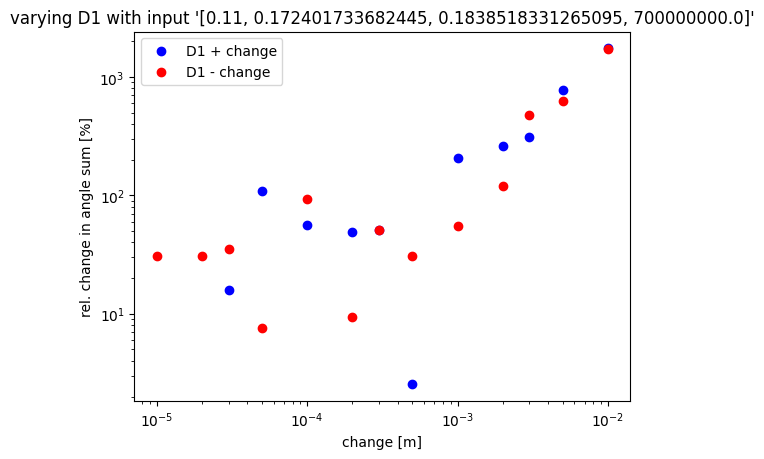

Succesfully updated all variables.
Varying D1 in range from 1 cm to 10 mikrometers


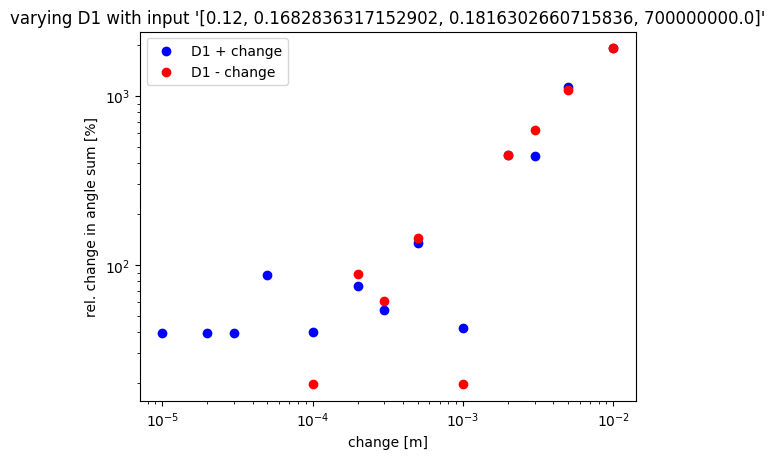

Succesfully updated all variables.
Varying D1 in range from 1 cm to 10 mikrometers


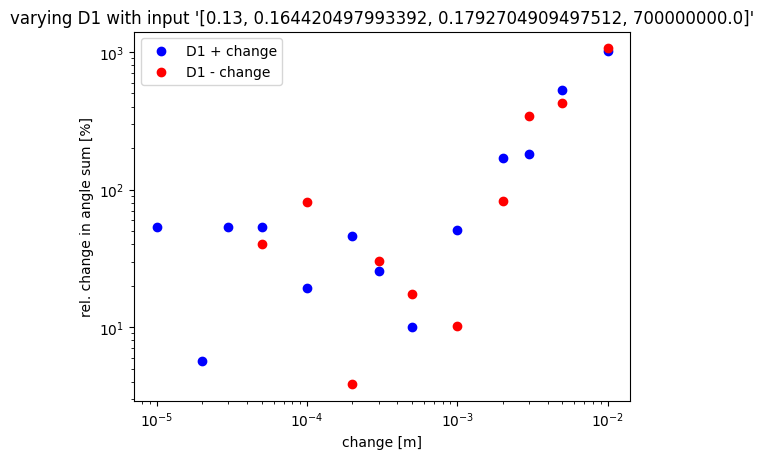

Succesfully updated all variables.
Varying D1 in range from 1 cm to 10 mikrometers


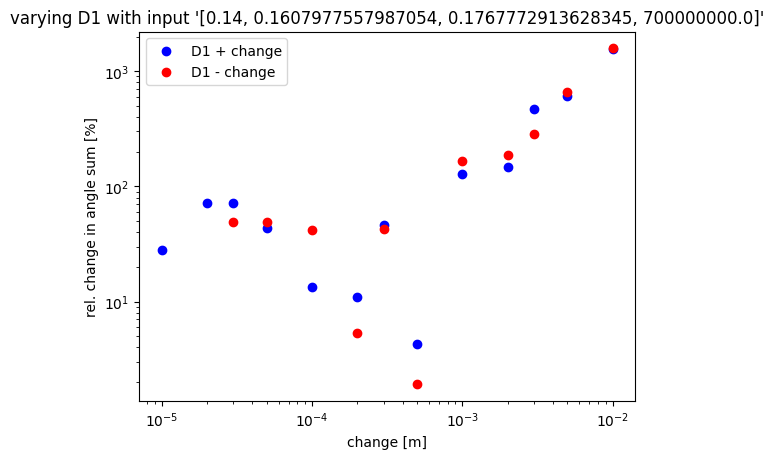

Succesfully updated all variables.
Varying D1 in range from 1 cm to 10 mikrometers


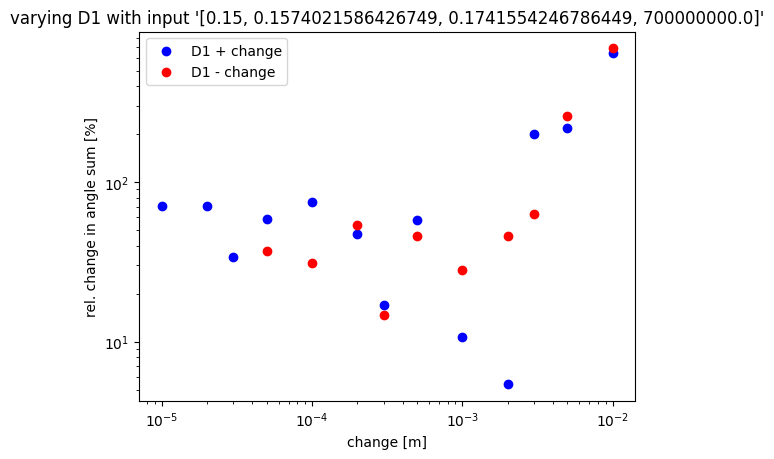

Succesfully updated all variables.
Varying D1 in range from 1 cm to 10 mikrometers


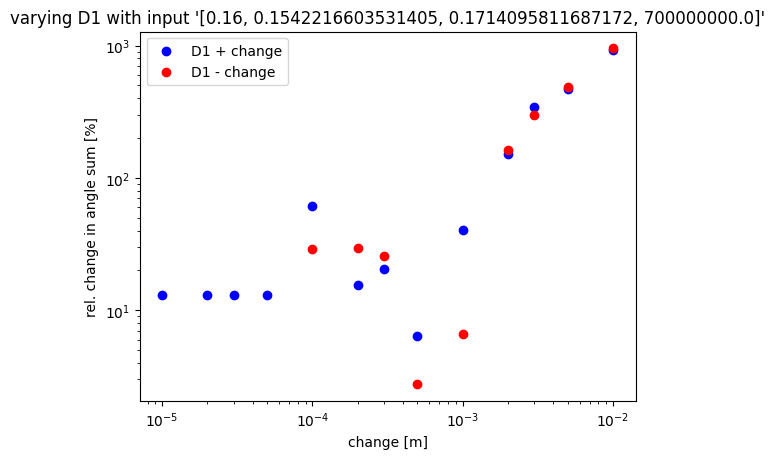

Succesfully updated all variables.
Varying D1 in range from 1 cm to 10 mikrometers


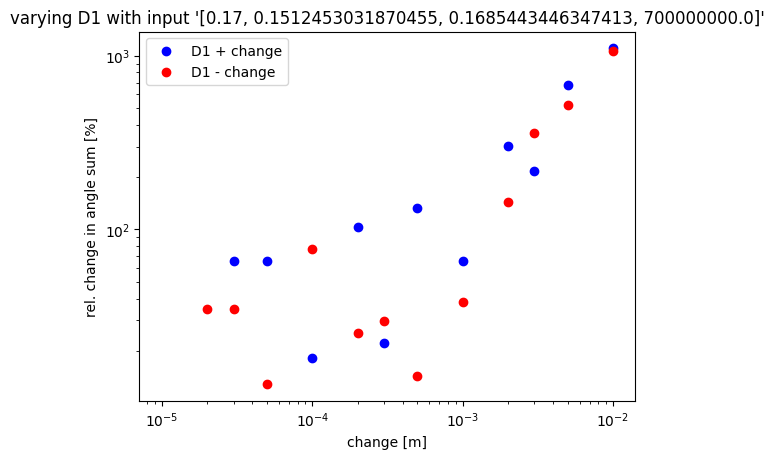

Succesfully updated all variables.
Varying D1 in range from 1 cm to 10 mikrometers


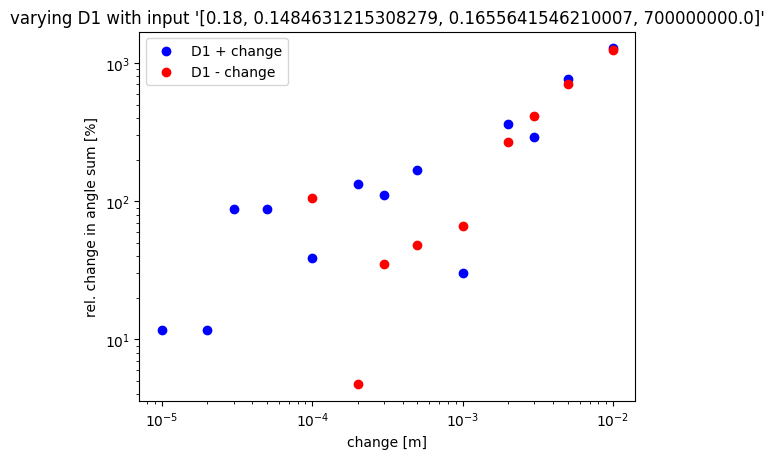

Succesfully updated all variables.
Varying D1 in range from 1 cm to 10 mikrometers


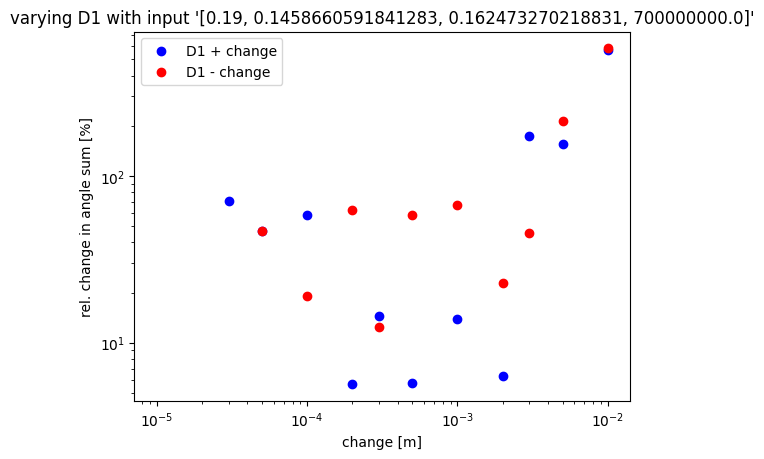

Succesfully updated all variables.
Varying D1 in range from 1 cm to 10 mikrometers


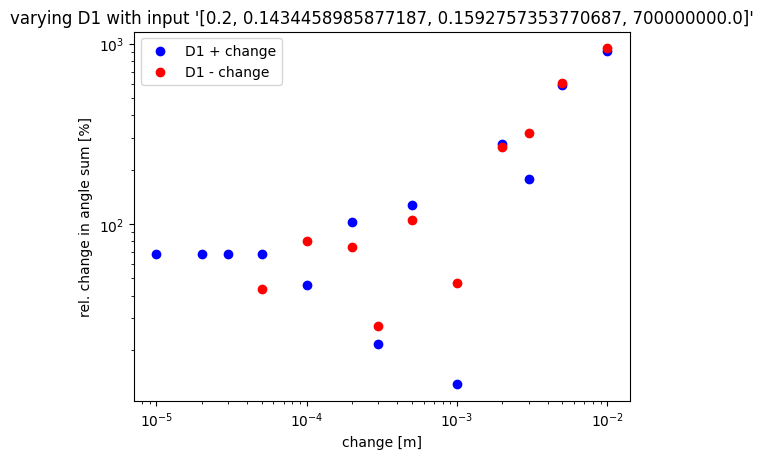

In [226]:
with open("../../MAXIMA/analyticalResultsD1.txt", "r") as file:
    setups = file.readlines()

for line in setups:
    line = line.split()
    runAna(float(line[0]), float(line[1]), float(line[2]), float(line[3]), 1)



In [ ]:
with open("../../MAXIMA/analyticalResultsD1.txt", "r") as file:
    setups = file.readlines()

for line in setups:
    line = line.split()
    runAna(float(line[0]), float(line[1]), float(line[2]), float(line[3]), 2)


In [ ]:
with open("../../MAXIMA/analyticalResultsD1.txt", "r") as file:
    setups = file.readlines()

for line in setups:
    line = line.split()
    runAna(float(line[0]), float(line[1]), float(line[2]), float(line[3]), 3)


In [ ]:
with open("../../MAXIMA/analyticalResultsD1.txt", "r") as file:
    setups = file.readlines()

for line in setups:
    line = line.split()
    runAna(float(line[0]), float(line[1]), float(line[2]), float(line[3]), 1)


In [214]:
def runAnaOffset(D1,D2, D3, momZ):
    #this function varies initial offset 
    
    topHatShapedQuads(True)
    update()
    
    input = [D1, D2, D3, momZ]

    difs = [0.005,0.003, 0.001, 0.0005,0.0003, 0.0001,0.00005 ,0.00003, 0.00001, 5.0E-6, 3.0E-6, 1.0E-6,5.0E-7, 3.0E-7, 1.0E-7, 5.0E-8, 3.0E-8, 1.0E-8,5.0E-9, 3.0E-9, 1.0E-9 ]
    #difs = [5.0E-7, 3.0E-7, 1.0E-7, 1E-8, 1E-9, 1E-10 ]

    graphDataMX = []
    graphDataMY = []
    graphDataPX = []
    graphDataPY = []
    
    #--------------------------------------------------------------------------------------------------------------------------
    print(f"Varying initial offset in x and y direction in range from 10 mrad to 0.01 mrad")
    
    for dif in difs:
        print(f"Running '{dif*1000}' mm")
        changeMom(1E+4,1E+4,momZ,0, 0)
        dataControl = runRef(D1,D2,D3,momZ, False)
        changeMom(xmom,ymom, momZ, dif, dif)
        dataTestP = runRef(D1,D2,D3, momZ, False)

        if dataControl == 1:
            print("Something is wrong with control data")
            return
        
        if dataTestP == 1:
            relChangeP = 1000
            relChangeM = 1000
        else:
            relChangeP = math.fabs(angleCalculation(dataControl)-angleCalculation(dataTestP))*100/angleCalculation(dataControl)
            relChangeM = math.fabs(angleCalculation(dataControl)-angleCalculationInverse(dataTestP))*100/angleCalculation(dataControl)
            plotRefXY2(D1,D2,D3,momZ,f"offset '{dif*1000}' mm")

        
        graphDataPX.append(dif*1e+3)
        graphDataPY.append(relChangeP)        
        graphDataMX.append(dif*1e+3)
        graphDataMY.append(relChangeM)   
    
    plt.scatter(graphDataPX, graphDataPY, color='blue', label='x offset in px != 0...')
    plt.scatter(graphDataMX, graphDataMY, color='red', label='y offset in px != 0...')
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.yscale('log')
    plt.xlabel('change [mm]')
    plt.ylabel('rel. change in angle sum [%]')
    plt.title(f"varying Px and Py with input '{input}'")
    plt.legend()
    plt.show()



Succesfully updated all variables.
Varying initial offset in x and y direction in range from 10 mrad to 0.01 mrad
Running '5.0' mm
Reference particle hit the cavity wall of Q1. Leaving...
Running '3.0' mm


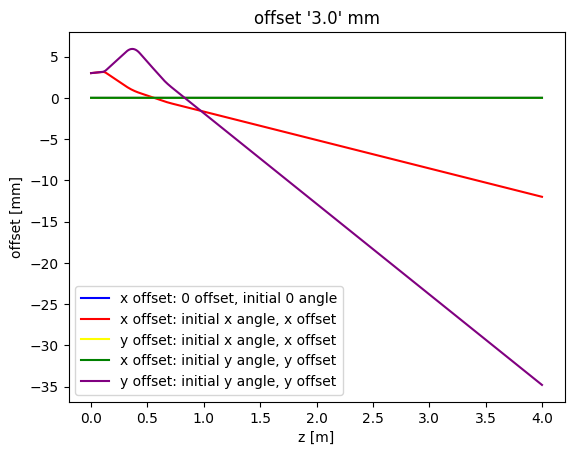

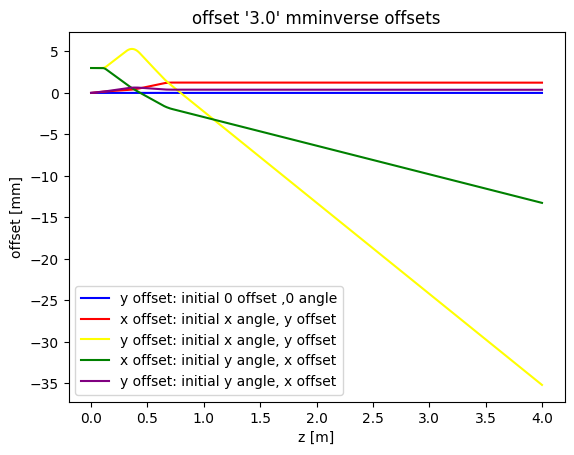

Running '1.0' mm


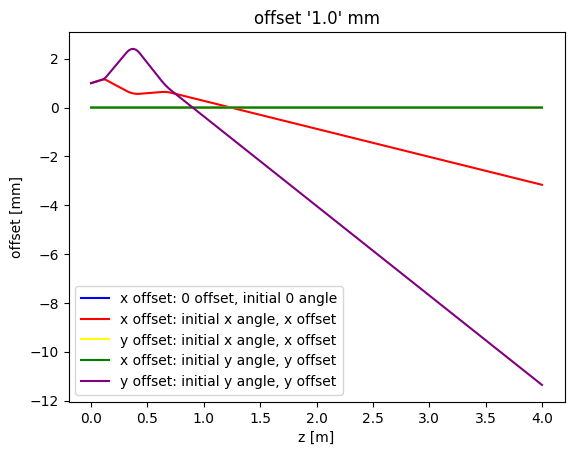

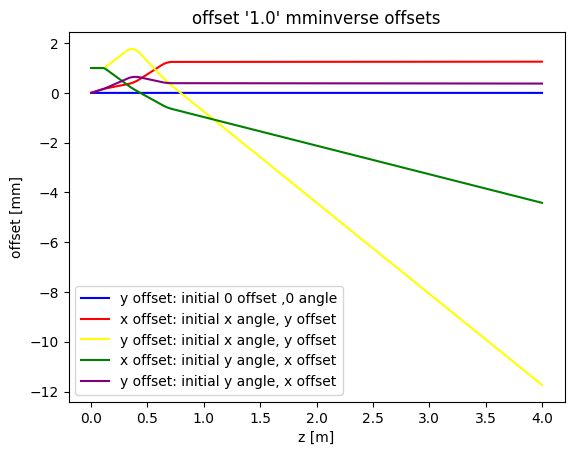

Running '0.5' mm


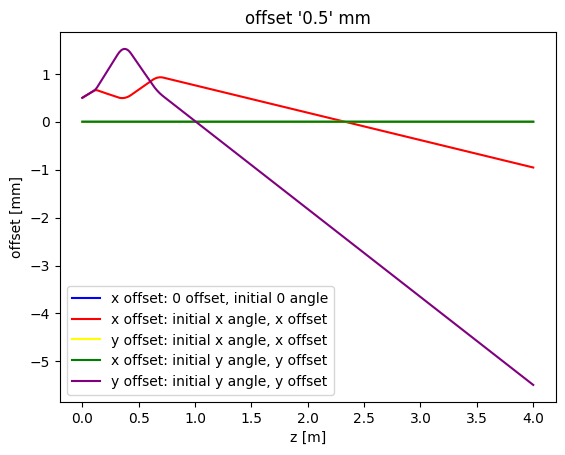

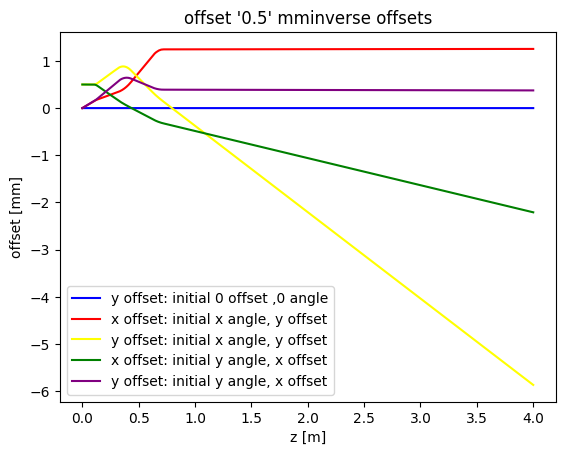

Running '0.3' mm


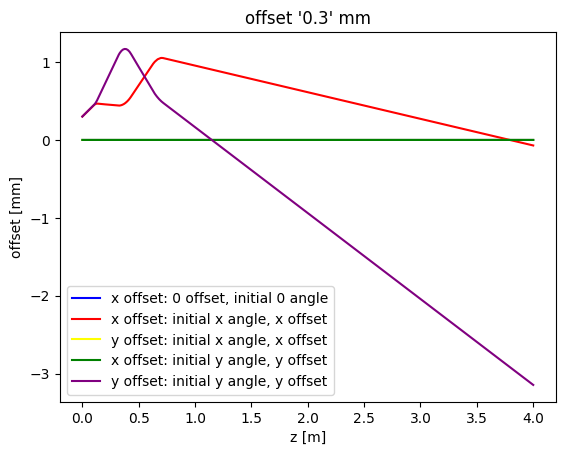

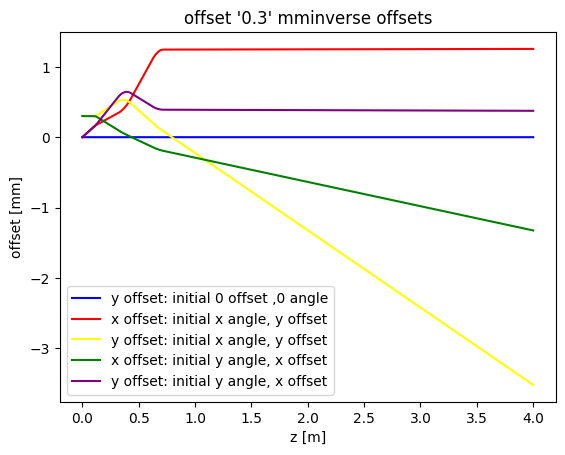

Running '0.1' mm


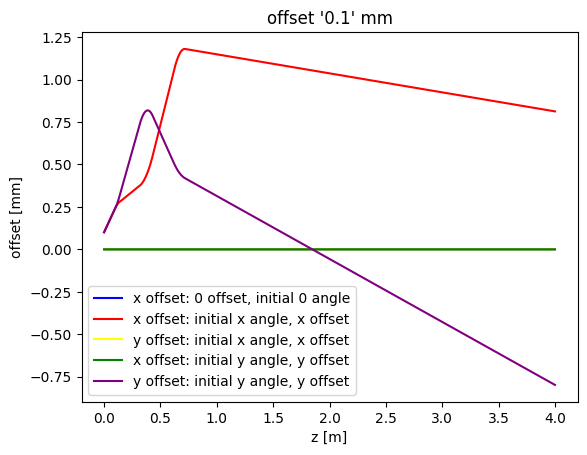

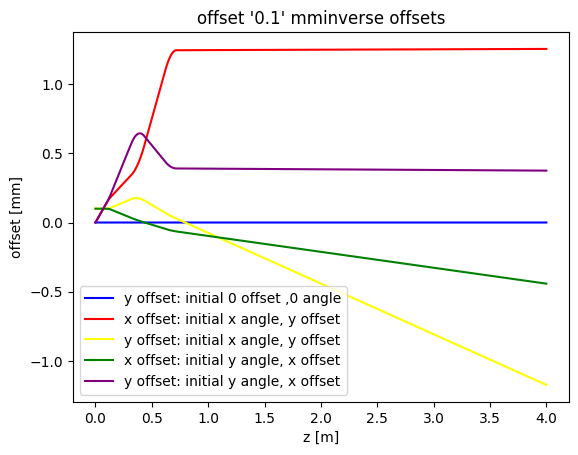

Running '0.05' mm


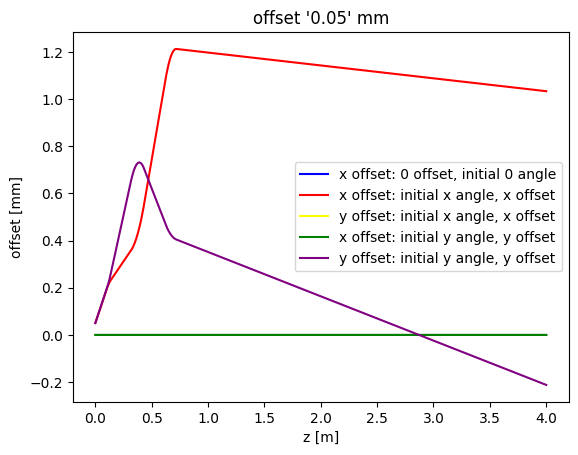

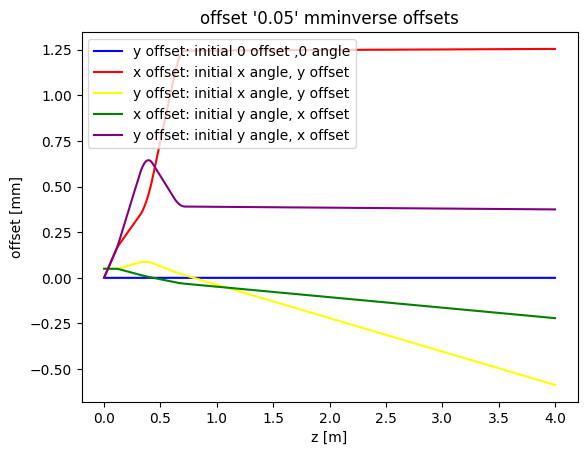

Running '0.030000000000000002' mm


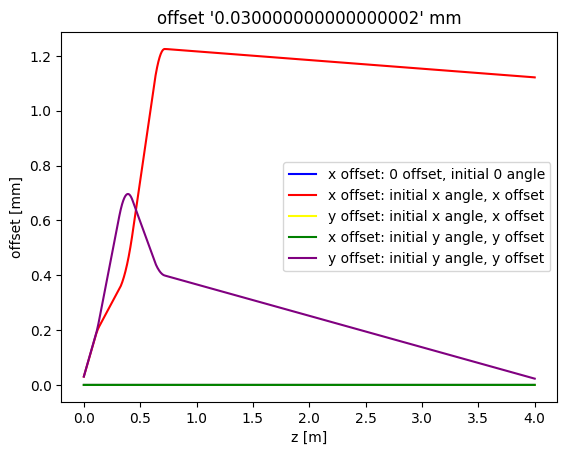

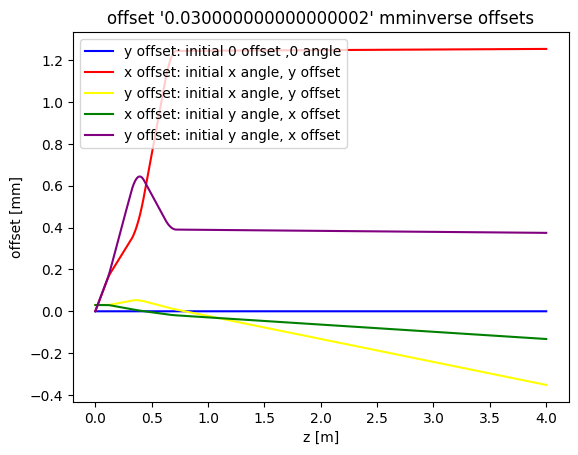

Running '0.01' mm


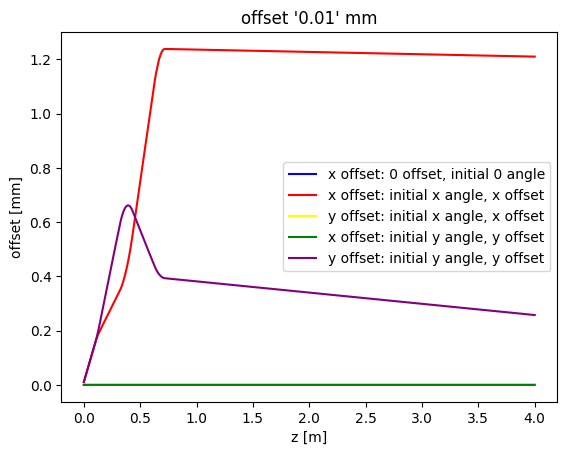

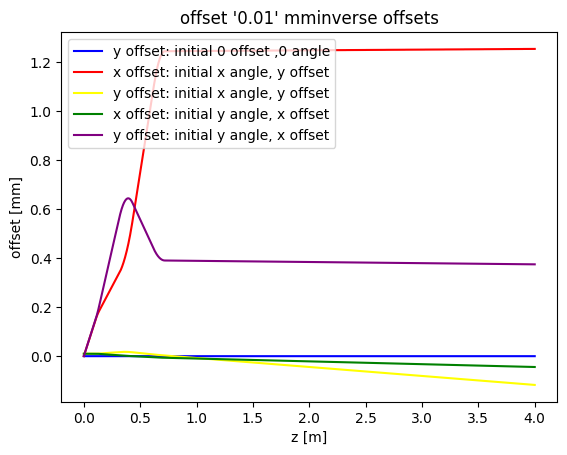

Running '0.005' mm


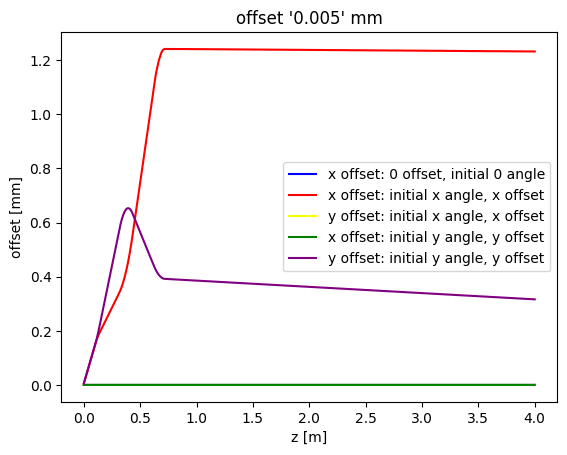

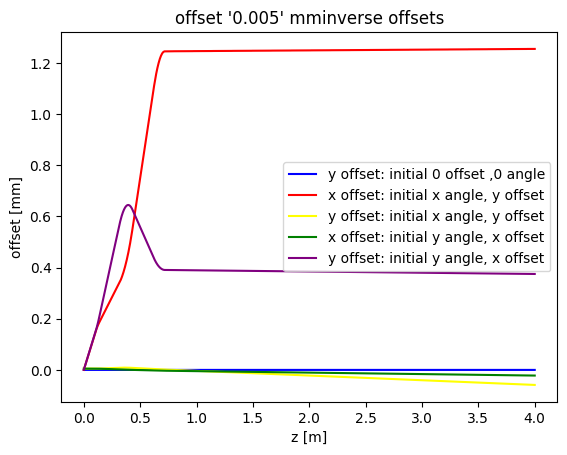

Running '0.003' mm


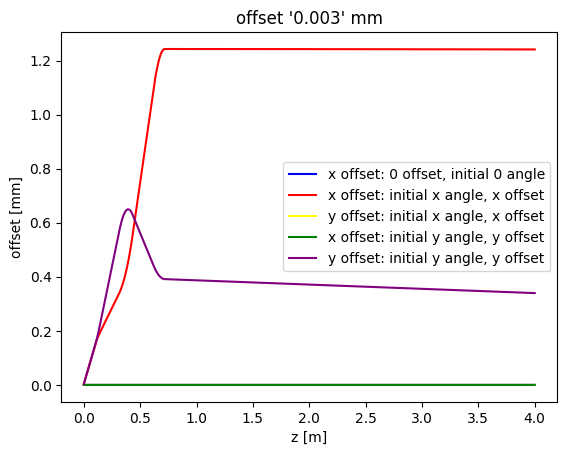

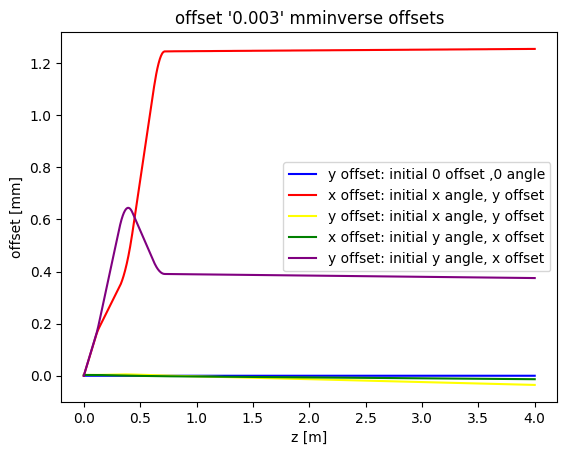

Running '0.001' mm


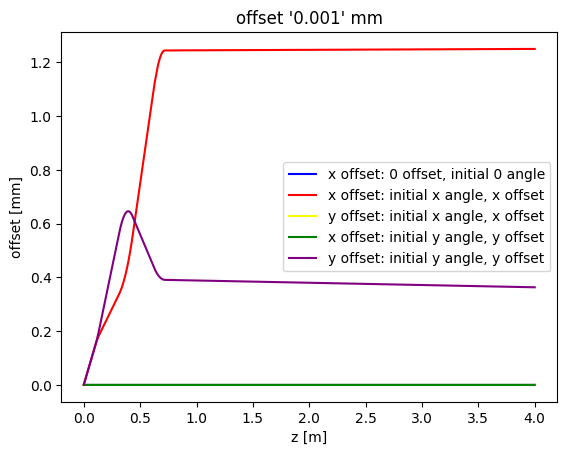

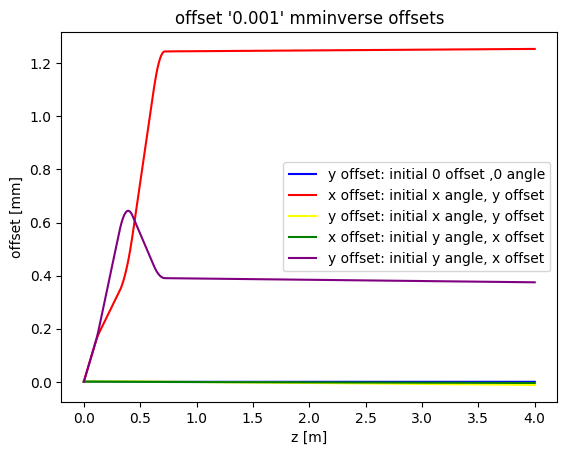

Running '0.0005' mm


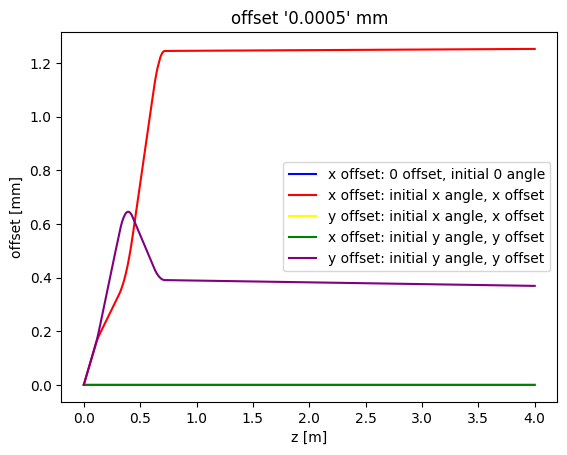

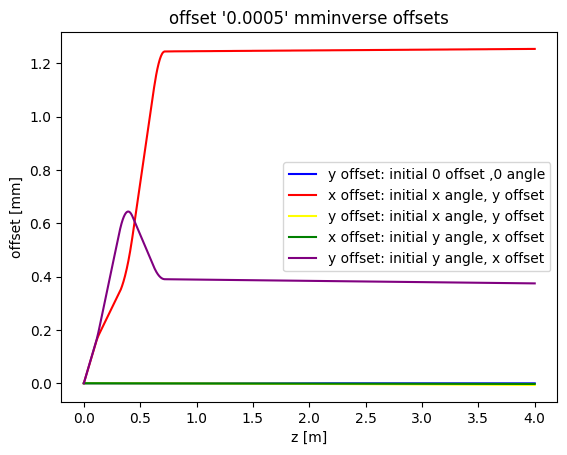

Running '0.0003' mm


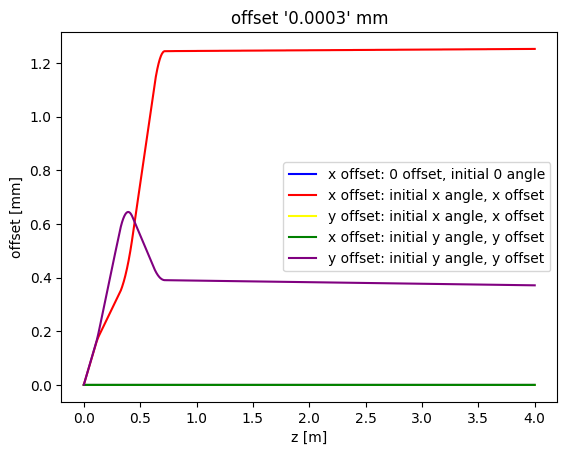

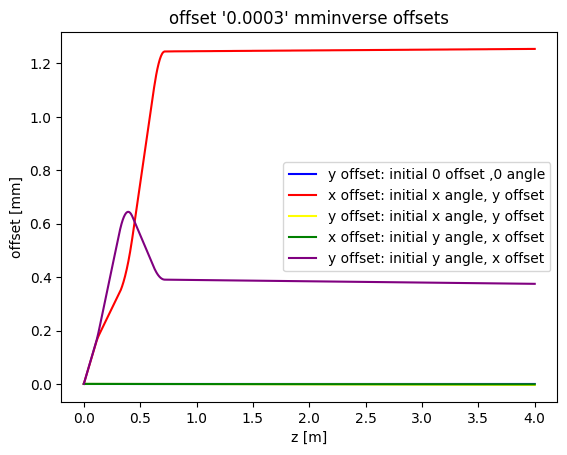

Running '9.999999999999999e-05' mm


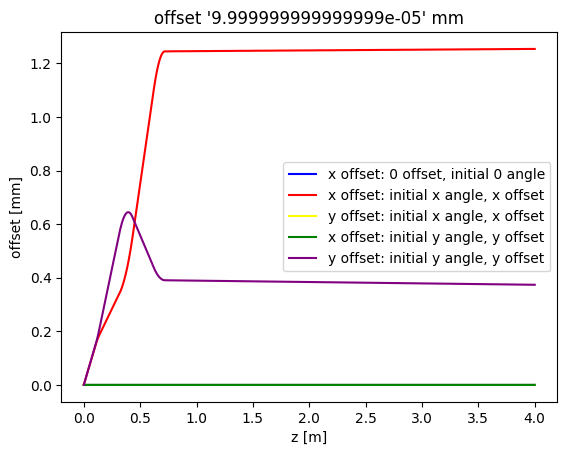

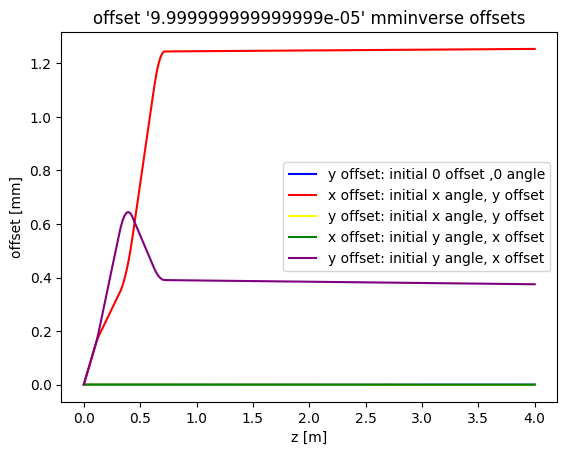

Running '4.9999999999999996e-05' mm


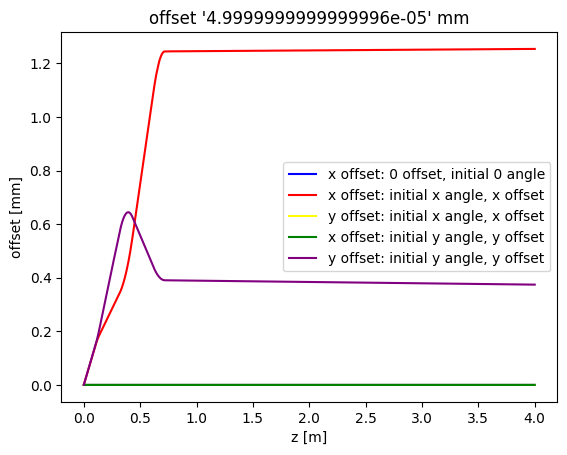

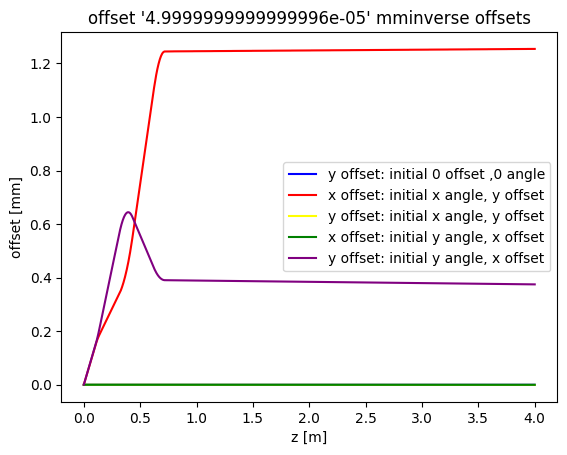

Running '2.9999999999999997e-05' mm


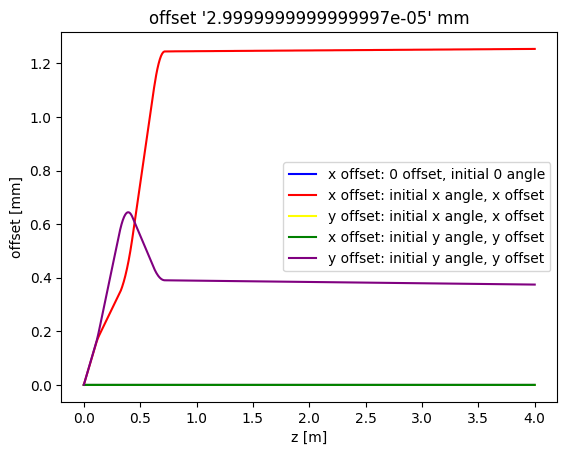

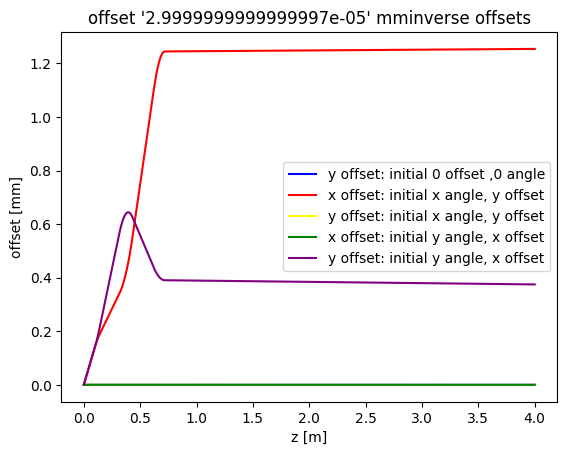

Running '1e-05' mm


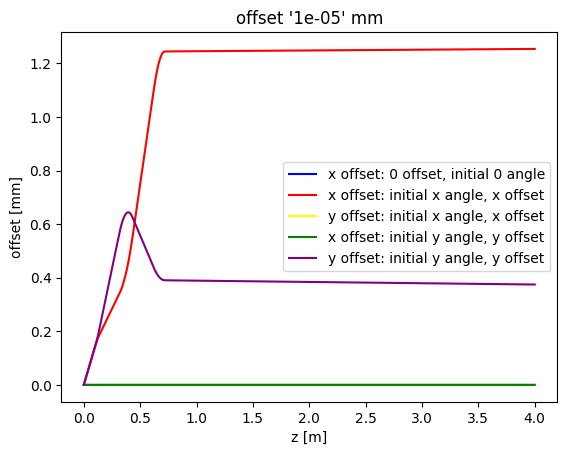

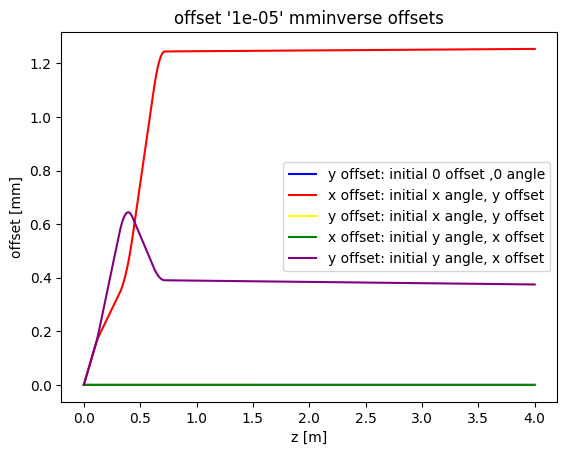

Running '5e-06' mm


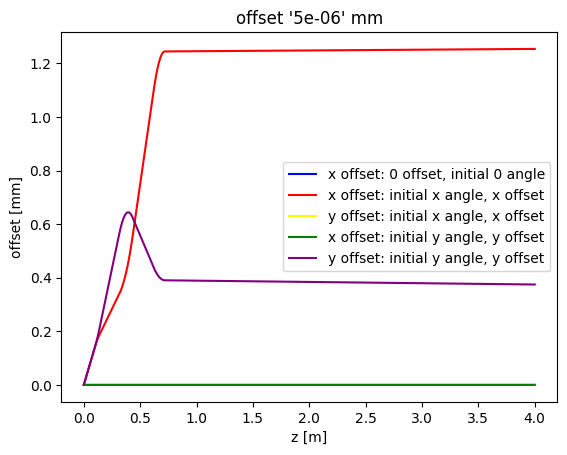

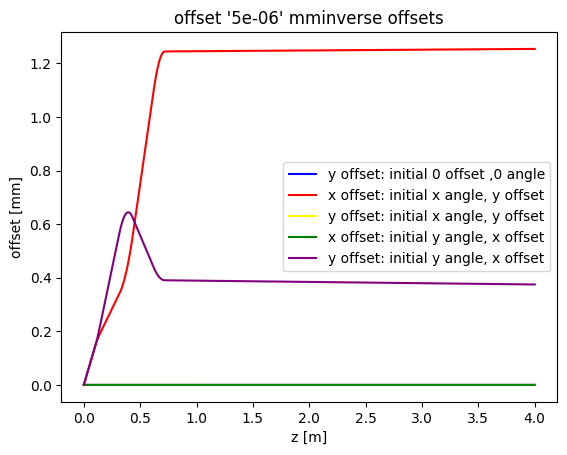

Running '3e-06' mm


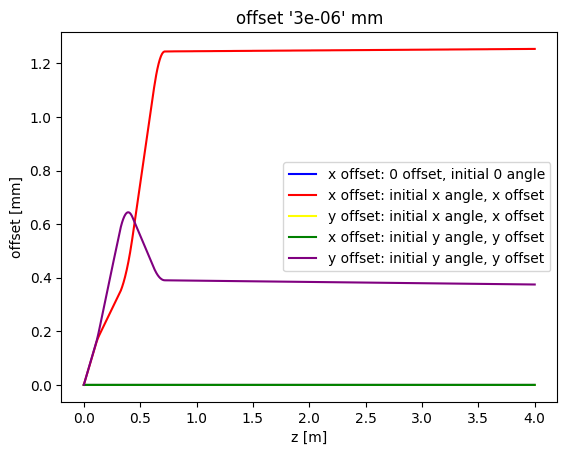

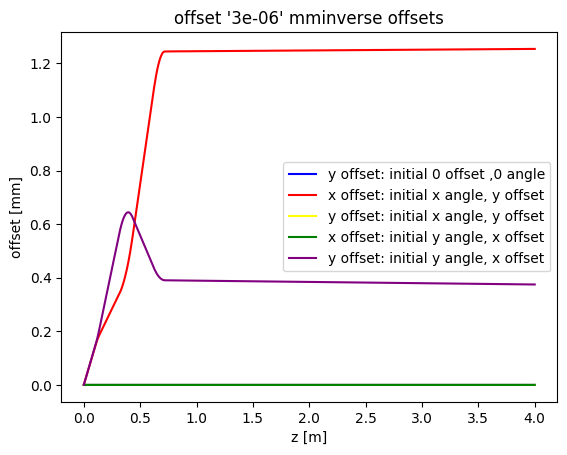

Running '1.0000000000000002e-06' mm


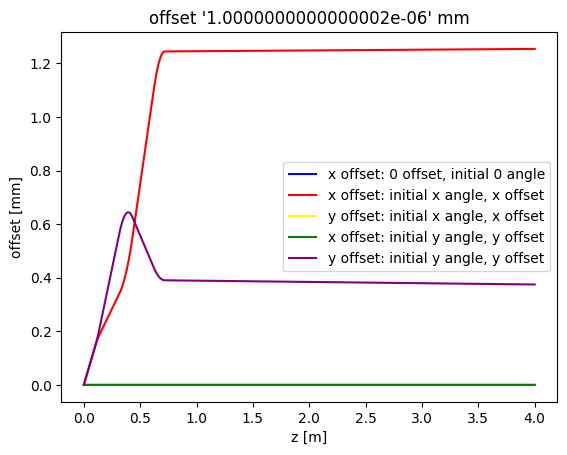

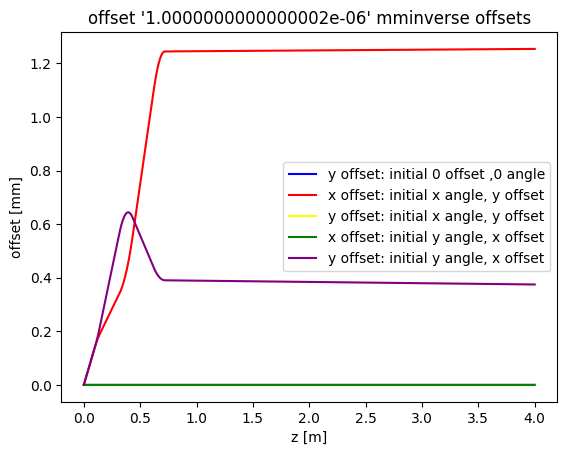

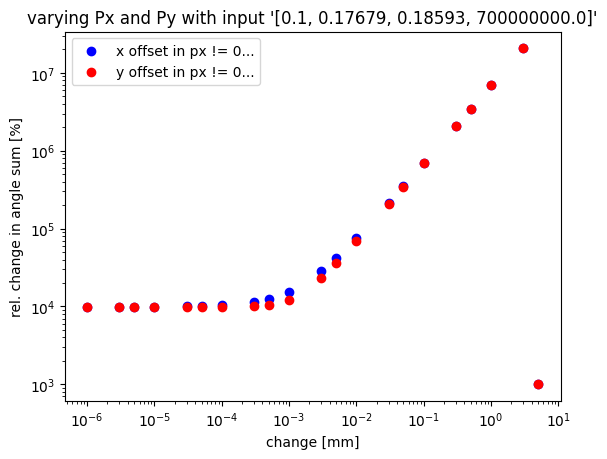

In [215]:
#study of sensitivity w.r.t. varying to D1, D2, D3
#runAna(0.10, 0.176790, 0.185930, 7e+8)
runAnaOffset(0.10, 0.176790, 0.185930, 7e+8)

# Beam analytics
Here are functions that do not run only on 3 reference particles, but run the whole beam. The beam has it's energy/momentum spread whether it is in the magnitude of longitudinal momentum or in transverse direction.

In [205]:
def runBeam(D1,D2,D3, momZ):

  
    Q1pos = D1 + lengthQ1/2
    Q2pos = D1 + lengthQ1 + D2 + lengthQ2/2
    Q3pos = D1 + lengthQ1 + D2 + lengthQ2 + D3 + lengthQ3/2

    changeInputData("Q_pos(1)",str(Q1pos) )
    changeInputData("Q_pos(2)",str(Q2pos) )
    changeInputData("Q_pos(3)",str(Q3pos) )
    changeMomZ(momZ)


    #here if needed, lines to generate new data for each run


    
    
    #if moreData, then provide tracking for each of the reference particles and return it for plotting
    outputMoreData = []
    changeInputData("Distribution", fileName + ".ini" )
    subprocess.run("source /opt/intel/oneapi/setvars.sh > out.txt && ./Astra " + fileName + " > output.txt", shell=True,check=True,executable='/bin/bash' )
    currentData = loadDataRef(setupLengthStr)
    '''
    #condition for 0. ref particle-> it cannot move
    if not isRef0Straight(loadDataRef("ref")[-1][7], loadDataRef("ref")[-1][8]):
        print(f"Reference 0 particle with 0 offset and 0 angle moved in setup with D1 = '{D1}', D2 = '{D2}' and D3 = '{D3}'.")
        return 1
    '''

    return currentData

In [206]:
def divergence():
    
    dataX = loadDataRef("Xemit")
    dataY = loadDataRef("Yemit")
    
    sum = (dataX[-1][4])**2 + (dataY[-1][4])**2

    return sum      

In [207]:
def funcBeam(D, D1, mom):

    data = runBeam( D1, D[0], D[1], mom)
    divSum = divergence()

    return divSum

In [208]:
def Beam(setupFileName):
# function which each setup runs only once and looks at the outcome of all 
    update()

    #boundaries for D2, D3    
    Dmin = [0.0,0.0]
    Dmax = [0.3,0.3]
    bounds = [(low, high) for low, high in zip(Dmin, Dmax)]
    
    with open("../../MAXIMA/" + setupFileName, "r") as file:
        stringdata = file.readlines()
        
    analyticData = []
    for line in stringdata:
        line = line.replace("\n","")
        line = line.split(" ")  
        analyticData.append(line)

    resultsTable = {
        "" : ["D1 [m]", "D2 [m]", "D3 [m]", "Pz [eV]", "F_ana_off [keV**2]", "F_ana_on [keV**2]", "F_num_off [keV**2]", "F_num_off [keV**2]", "Delta D2_num_off [mm]" , "Delta D3_num_off [mm]", "Delta D2_num_off [mm]" , "Delta D3_num_off [mm]"]
    }

    df = pd.DataFrame(resultsTable)
    i = 1
    for row in analyticData:
        #first run the analytical solution and show plots
        topHatShapedQuads(True)
        data = runBeam(float(row[0]),float(row[1]), float(row[2]), float(row[3]))
        sumAOff = divergence()
        plotBeam(data, f"Analytic solution, '{row}', top hat fields")

        topHatShapedQuads(False)
        data = runBeam(float(row[0]),float(row[1]), float(row[2]), float(row[3]))
        sumAOn = divergence()
        plotBeam(data, f"Analytic solution, '{row}', with fringe fields")

        topHatShapedQuads(True)
        resNOff = sc.optimize.minimize(funcBeam, (0.15, 0.15),method="Powell", bounds=bounds,tol=1e-8, args=(float(row[0]), float(row[3])))
        data = runBeam(float(row[0]),*resNOff.x , float(row[3]))
        sumNOff = divergence()
        plotBeam(data, f"Numerical solution, ['{row[0]}', '{resNOff.x[0]}', '{resNOff.x[1]}', '{row[3]}'], top hat fields")

        topHatShapedQuads(False)
        resNOn = sc.optimize.minimize(funcBeam, (0.15, 0.15),method="Powell", bounds=bounds,tol=1e-8, args=(float(row[0]), float(row[3])))
        data = runBeam(float(row[0]),*resNOn.x , float(row[3]))
        sumNOn = divergence()
        plotBeam(data, f"Numerical solution, ['{row[0]}', '{resNOn.x[0]}', '{resNOn.x[1]}', '{row[3]}'], with fringe fields")

        
        row.append(sumAOff)
        row.append(sumAOn)
        row.append(sumNOff)
        row.append(sumNOn)
        row.append(math.fabs(float(row[1]) - resNOff.x[0])*1000 )
        row.append(math.fabs(float(row[2]) - resNOff.x[1])*1000 )
        row.append(math.fabs(float(row[1]) - resNOn.x[0])*1000 )
        row.append(math.fabs(float(row[2]) - resNOn.x[1])*1000 )
        
        df['setup ' + str(i)] = row
        
        i += 1
        
    
    return df
    

In [209]:
def plotBeam(data, title):
    #this function plots px over py of all particles in a beam

    px = []
    py = []
    for line in data:
        px.append(line[3]/1e+6)
        py.append(line[4]/1e+6)
    

    
    # Create a 2D histogram (density plot)
    plt.figure(figsize=(8, 6))
    plt.hist2d(px, py, bins=30, cmap='Blues')
    
    # Add a color bar to show the density scale
    plt.colorbar(label='Density')
    
    # Set labels and title
    plt.xlabel('px [MeV]')
    plt.ylabel('py [MeV]')
    plt.title(title)

    plt.show()
    
    return   
